<a href="https://colab.research.google.com/github/Ameeki/nlp22/blob/main/hw2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [3]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [4]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-02 06:59:25--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.05s   

2022-02-02 06:59:25 (23.0 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2022-02-02 06:59:25--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [5]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [6]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [7]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [8]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [9]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words| Bag of Words should be a good method because it measures the presence of vocabulary words from a huge dataset. So if the dataset where we derive the words from is similar to the document we test on, bag of words would have very high accuracy. | 0.795 ||
|Feature 1| Given that the dataset seems to be proper sentences, I thought that classifying via Parts of Speech would be effective, especially for heavily used prepositions like "it", "I", "you". I created 20-word arrays with the top used words for different Parts of Speech. | 0.528 ||
|Feature 2| Since the data seems to consist of movie reviews, I took genres to categorize them. Ideally, there would be more genres and words, but since they are a common theme, it should be a good feature.| 0.539 ||
|Feature 3| Because gender is a common binary in movies, I added arrays with the top words that describe men vs women. Hoping that character analysis would be a top feature of movie reviews, I used that as a parameter.| 0.521 ||

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [10]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        feats[word]=1

    return feats

In [11]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 23764, Train accuracy: 1.000, Dev accuracy: 0.795


In [16]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    # going to try parts of speech, making arrays of top 20 words for each category
    # source for top words: www.englishclub.com

    verbs = ["be", "have", "do", "say", "get", "make", "go", 
             "know", "take", "see", "come", "think", "look", 
             "want", "give", "use", "find", "tell", "ask", "work"]
    adjectives = ["good", "new", "first", "last", "long", "great", 
                  "little", "own", "other", "old", "right", "big", 
                  "high", "different", "small", "large", "next", 
                  "early", "young", "important"]
    nouns = ["time", "person", "year", "way", "day", "thing", "man",
             "world", "life", "hand", "part", "child", "eye", "woman",
             "place", "work", "week", "case", "point", "government"]
    pronouns = ["it", "I", "you", "he", "they", "we", "she", "who", 
                "them", "me", "him", "one", "her", "us", "something", 
                "nothing", "anything", "himself", "everything", "someone"]
    prepositions = ["of", "in", "to", "with", "on", "at", "from", "by", 
                    "from", "by", "about", "as", "into", "like", "through", 
                    "after", "over", "between", "out", "against", "during"]
    
    for word in words:
        word=word.lower()
        if word in verbs:
            feats["verb"] = 1
        if word in adjectives:
            feats["adjective"] = 1
        if word in nouns:
            feats["noun"] = 1
        if word in pronouns:
            feats["pronoun"] = 1
        if word in prepositions:
            feats["preposition"] = 1
               
    return feats


In [15]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 5, Train accuracy: 0.520, Dev accuracy: 0.528


In [17]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.

    # by genre, used https://reversedictionary.org/ to generate some words
    
    feats = {}
    words = nltk.word_tokenize(text)

    romance = ["romcom", "romance", "romantic", "romanticize", "comic", "sitcom", "date", 
             "love", "affair", "cute", "marry", "relationship", "flirt", 
             "single", "passion", "together", "heartthrob", "kiss", "attract", "couple"]
    thriller = ["thriller", "psycho", "chills", "suspense", "horror", "epic", 
                  "mystery", "kill", "scary", "edge"]
    comedy = ["satire", "comedy", "slapstick", "parody", "laugh", "laughter", 
                  "fun", "irony", "smile", "funny", "humorous", "giggle", 
                  "chuckle", "lol", "quirky"]


    for word in words:
        word=word.lower()
        if word in romance:
            feats["romance"] = 1
        if word in thriller:
            feats["thriller"] = 1
        if word in comedy:
            feats["comedy"] = 1
            
    return feats

In [18]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 3, Train accuracy: 0.543, Dev accuracy: 0.539


In [19]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    woman = ["female", "feminine", "woman", "girl", "women", "maternal", "mother", "mom", 
             "daughter", "grandma", "queen", "princess", "lady", "Emily", "wife", "beautiful", "widow", 
             "girlfriend", "pregnant", "gal", "pink"]
    man = ["male", "masculine", "man", "boy", "men", "patriarchy", "father", "dad", 
             "son", "grandpa", "king", "prince", "gentleman", "John", "husband", "handsome", "chap", 
             "boyfriend", "bachelor", "guy", "blue"]


    for word in words:
        word=word.lower()
        if word in woman:
            feats["woman"] = 1
        if word in man:
            feats["man"] = 1
            
    return feats

In [20]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 2, Train accuracy: 0.530, Dev accuracy: 0.521


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [21]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [22]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 23769, Train accuracy: 1.000, Dev accuracy: 0.783


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


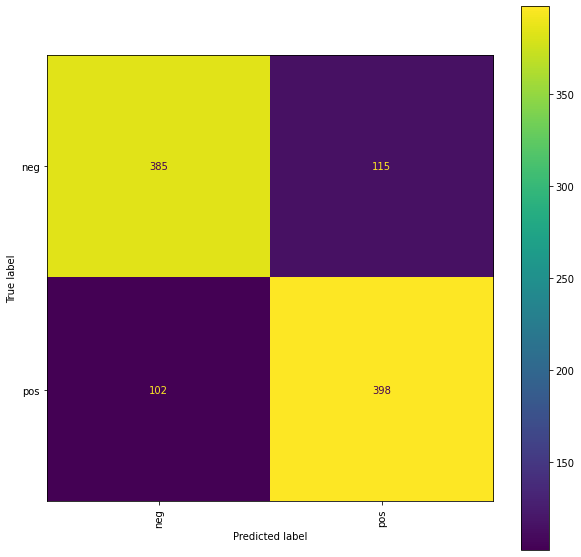

In [23]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [24]:
big_classifier.printWeights(n=25)

pos	0.865	great
pos	0.852	It
pos	0.803	very
pos	0.686	excellent
pos	0.686	amazing
pos	0.597	My
pos	0.550	One
pos	0.520	perfect
pos	0.515	simple
pos	0.507	top
pos	0.503	in
pos	0.501	best
pos	0.495	enjoyed
pos	0.487	fun
pos	0.481	new
pos	0.474	relationship
pos	0.460	young
pos	0.457	thought
pos	0.452	incredible
pos	0.451	takes
pos	0.444	friends
pos	0.441	saw
pos	0.431	us
pos	0.430	series
pos	0.420	different

neg	-1.062	worst
neg	-0.825	acting
neg	-0.801	boring
neg	-0.735	would
neg	-0.711	stupid
neg	-0.666	waste
neg	-0.623	idea
neg	-0.621	?
neg	-0.618	watching
neg	-0.617	there
neg	-0.565	poor
neg	-0.563	money
neg	-0.562	nothing
neg	-0.545	horrible
neg	-0.544	even
neg	-0.528	me
neg	-0.523	poorly
neg	-0.515	bad
neg	-0.493	something
neg	-0.482	worse
neg	-0.475	actors
neg	-0.463	no
neg	-0.456	act
neg	-0.452	instead
neg	-0.445	awful



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [25]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [26]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,0.999986,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1822,0.998006,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to Fulci's hit Zombi 2, with Zombi 2 itself being of course a marketing ploy to trick people into thinking it was a sequel to George A. Romero's Dawn of the Dead aka Zombi. Confusing enough? Basically, none of the films have anything to do with one another, but who cares when they make money. I guess Fulci himself start..."
2,1206,0.994106,neg,pos,"Plot Synopsis: Hong Kong, 1966. Paul Wagner, the man who built the Victoria Tunnel, is murdered along with his wife by his associates. His twin sons, Chad & Alex, are split apart. 25 years later, Chad, a karate instructor in Los Angeles, & Alex, a smuggler living in Hong Kong, join forces to avenge their parents' murder & rightfully claim the tunnel.This is the second time that Jean-Claude Van..."
3,1702,0.992855,neg,pos,"David Arquette is a young and naive home security alarmsalesman taken under the wing of Stanley Tucci. Arquette is agolden boy, scoring a big sale on his first call- to widow KateCapshaw and her dopey son Ryan Reynolds. Things are goingwell for Arquette, he is appearing in commercials for the securityfirm and he is falling in love with Capshaw.Then Tucci and his right hand woman Mary McCormack..."
4,1783,0.990527,pos,neg,"Ira Levin's Deathtrap is one of those mystery films in the tradition of Sleuth that would be very easy to spoil given any real examination of the plot of the film. Therefore I will be brief in saying it concerns a play, one man who is a famous mystery playwright, another man who is a promising writer, the playwright's wife who is much younger and sexier than the role should have been, and one ..."
5,1784,0.990278,pos,neg,"The only complaint I have about this adaptation is that it is sexed-up. Things that were only hinted at in the novel are shown on-screen for some weird reason. Did they think the audience would be too stupid to understand if they were not shown everything out-right? Other than that, this is very good-quality. All the actors do marvelous jobs bringing their characters to life. For the shallow w..."
6,1916,0.989783,neg,pos,"Having read the other comments on this film, I would like to share my own view that this is one tough movie to see unless you are a total Brooksophile. I am not.When looked at by a purely objective observer, the film is an unbalanced narrative that presents us with more undistilled neuroses than are capable of being absorbed in one sitting. It is quite difficult to watch. The Brooks character ..."
7,1959,0.988182,pos,neg,"This is one of the best episode from the second season of MOH, I think Mick Garris has a problem with women... He kill'em all, they are often the victims (Screwfly solution, Pro-life, Valerie on the stairs, I don't remember the Argento's episode in season 1, etc., obviously Imprint). I think he enjoys to watch women been burn, torture, mutilated and I don't know. Never least ""Right to die"" is ..."
8,1726,0.987296,neg,pos,"I gave this movie a 2, and though I consider myself a science fiction fan, I found this movie very difficult to take seriously. It was on AMC one late night, and I'm glad I saw it for free. This movie is probably good for a few laughs, but not much more.The special effects are about average for the time period - not awful, but not great, either. Of course we know more about Mars now than we di..."
9,1982,0.986521,neg,pos,"The major flaw with the film is its uninspired script. It plods back and forth 

In [18]:
example = "Mary and Samantha love each other. They arrived at the bus station early but waited until noon for the bus. They hate it but love each other."
simple_featurize(example)

{'contains_negative_word': 1, 'contains_positive_word': 1}